In [25]:
using IntervalArithmetic
using LaTeXStrings
using Plots

In [26]:
include("./heatmap/index.jl")
include("./method1/index.jl")
include("./method2/index.jl")
include("./method3/index.jl")
include("./method4/index.jl")
include("./intervalPCM/index.jl")
include("./twofoldInterval/index.jl")
include("./twofoldIntervalPCM/index.jl")

print()

In [27]:
function revisedMat(
        A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}
        ) where {T <: Real}
    Ã₁⁻, Ã₁⁺ = generateRevisedMatrix(A₁)
    Ã₂⁻, Ã₂⁺ = generateRevisedMatrix(A₂)
    return ((Ã₁⁻, Ã₁⁺), (Ã₂⁻, Ã₂⁺))
end

revisedMat (generic function with 1 method)

In [28]:
function method1(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    A = intervalPCM2TwofoldIntervalPCM(A₁, A₂)
    result = solveLP_m1(A)
    Â = updatePCM_m1(A, result)
    return Â
end

method1 (generic function with 1 method)

In [29]:
function  method2(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    εᶿ = solveIndividualCancellingLP_m2([A₁, A₂])
    result = solveApproximationLP_m2([A₁, A₂], εᶿ)
    A = importance2TwofoldIntervalPCM_m2(result)
    return A
end

method2 (generic function with 1 method)

In [30]:
function method3(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    approximationResults = solveApproximationLP_m3.([A₁, A₂])
    tBoundaries = calculateTBoundaries_m3.(approximationResults)
    result = solveConcatLP_m3(approximationResults, tBoundaries)
    Â = generatePCM_m3(result)
    return Â
end

method3 (generic function with 1 method)

In [31]:
function method4(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    results = solveApproximationLP_m4.([A₁, A₂])
    A = generateTwofoldIntervalMatrix_m4(results)
    result = solveCancellingLP_m4(A)
    Â = updatePCM_m4(A, result)
    return Â
end

method4 (generic function with 1 method)

In [36]:
# 対角成分以外の算術平均
function mean(A::Matrix{T})::T where {T <: Real}
    m, n = size(A)

    if m != n return 0 end
    if n == 1 return 0 end

    a = 0
    for i = 1:m, j = 1:n
        if i == j continue end
        a += A[i,j]
    end

    return a / n / (n-1)
end

function plotAll(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
    display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

    m = 2 # DM の数

    revisedMatrices = revisedMat(A₁, A₂)
    resultMatrices = twofoldIntervalMatrix2intervalMatrices.(
        [method1(A₁, A₂), method2(A₁, A₂), method3(A₁, A₂), method4(A₁, A₂)])
    
    p = []; e = []; a = []; indmat = []
    for k = 1:length(resultMatrices)
        h = []; f = []; indrow = []
        Âₖ⁻, Âₖ⁺ = resultMatrices[k]
        for l = 1:m
            Ãₗ⁻, Ãₗ⁺ = revisedMatrices[l]

            title⁻ = L"\frac{\left| \tilde{A}_{%$(l)ij}^- \cap \hat{A}_{%$(k)ij}^- \right|}{\left| \tilde{A}_{%$(l)ij}^- \cup \hat{A}_{%$(k)ij}^- \right|}"
            title⁺ = L"\frac{\left| \tilde{A}_{%$(l)ij}^+ \cap \hat{A}_{%$(k)ij}^+ \right|}{\left| \tilde{A}_{%$(l)ij}^+ \cup \hat{A}_{%$(k)ij}^+ \right|}"

            heatmap⁻, numberOfEmptySet⁻, indices⁻ = plotConincidenceIndices(Ãₗ⁻, Âₖ⁻, title⁻)
            heatmap⁺, numberOfEmptySet⁺, indices⁺ = plotConincidenceIndices(Ãₗ⁺, Âₖ⁺, title⁺)

            push!(h, heatmap⁻); push!(h, heatmap⁺)
            push!(f, numberOfEmptySet⁻); push!(f, numberOfEmptySet⁺)
            push!(indrow, indices⁻); push!(indrow, indices⁺)
        end

        push!(p, h); push!(e, f); push!(a, [Âₖ⁻, Âₖ⁺])
        push!(indmat, indrow)
    end

    for i = eachindex(p)
        A = intervalPCM2TwofoldIntervalPCM(a[i][1], a[i][2])
        display(L"A_{%$(i)}^+ = %$(twofoldIntervalMatrixLaTeXString(A))")
        display(plot(p[i]..., layout=(1, 4), size=(1000, 250), legend=false))
        display("非対角成分の算術平均: $(round(mean(indmat[i][1]), digits=3)), $(round(mean(indmat[i][2]), digits=3)), $(round(mean(indmat[i][3]), digits=3)), $(round(mean(indmat[i][4]), digits=3))")
        display("空集合の数　　　　　: $(e[i][1]), $(e[i][2]), $(e[i][3]), $(e[i][4])")
    end
end

plotAll (generic function with 1 method)

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.5, 3.5 \right] & \left[ 8.0, 10.0 \right] \\ \left[ 0.286, 0.4 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.0, 4.0 \right] \\ \left[ 0.1, 0.125 \right] & \left[ 0.25, 0.5 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.0, 4.0 \right] & \left[ 7.0, 12.0 \right] \\ \left[ 0.25, 0.5 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.0, 5.0 \right] \\ \left[ 0.083, 0.143 \right] & \left[ 0.2, 0.5 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_{1}^+ = \begin{bmatrix} \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[   2.0, \left[ 2.625, 2.625 \right],   4.0 \right] & \left[ 6.667, \emptyset,  12.0 \right] \\ \left[  0.25, \left[ 0.381, 0.381 \right],   0.5 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[   2.0, \left[ 2.667, 2.667 \right],   5.0 \right] \\ \left[ 0.083, \emptyset,  0.15 \right] & \left[   0.2, \left[ 0.375, 0.375 \right],   0.5 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] \end{bmatrix}$"

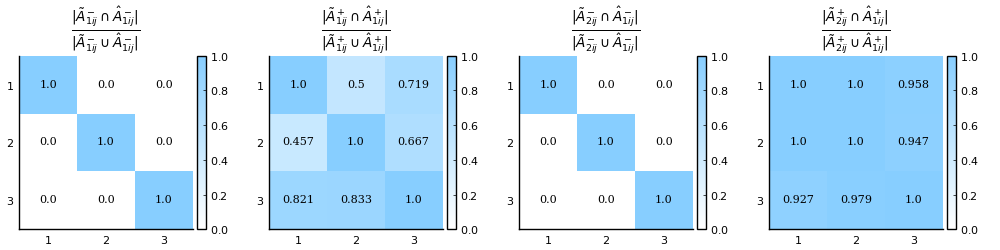

"非対角成分の算術平均: 0.0, 0.666, 0.0, 0.969"

"空集合の数　　　　　: 6, 0, 6, 0"

"\$A_{2}^+ = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   2.0, \\left[   2.5,   3.5 \\right],   4.0 \\right] & \\left[ 6.889, \\left[   8.0,  10.0 \\right],  12.0 \\right] \\\\ \\left[  0.25, \\left[ 0.286,   0.4 \\right],   0.5 \\right] & \\left[ " ⋯ 30 bytes ⋯ "ght],   1.0 \\right] & \\left[   2.0, \\left[ 2.515, 3.635 \\right], 5.167 \\right] \\\\ \\left[ 0.083, \\left[   0.1, 0.125 \\right], 0.145 \\right] & \\left[ 0.194, \\left[ 0.275, 0.398 \\right],   0.5 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

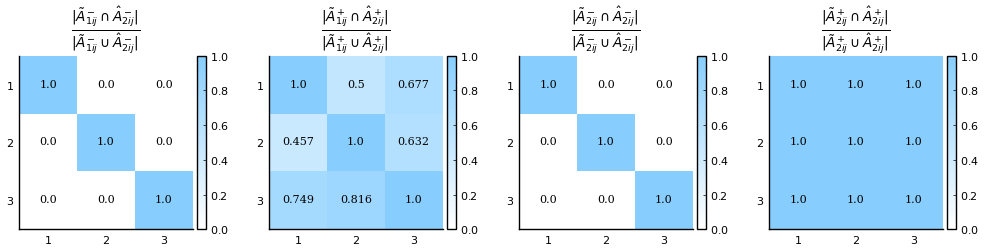

"非対角成分の算術平均: 0.0, 0.638, 0.0, 1.0"

"空集合の数　　　　　: 0, 0, 2, 0"

"\$A_{3}^+ = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   2.5, \\left[ 2.925,   3.3 \\right], 3.589 \\right] & \\left[ 9.524, \\left[  10.0, 10.768 \\right], 11.845 \\right] \\\\ \\left[ 0.279, \\left[ 0.303, 0.342 \\right],   0.4 \\right] & \\left" ⋯ 32 bytes ⋯ "ght],   1.0 \\right] & \\left[ 2.857, \\left[  3.03, 3.795 \\right],   4.4 \\right] \\\\ \\left[ 0.084, \\left[ 0.093,   0.1 \\right], 0.105 \\right] & \\left[ 0.227, \\left[ 0.264,  0.33 \\right],  0.35 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

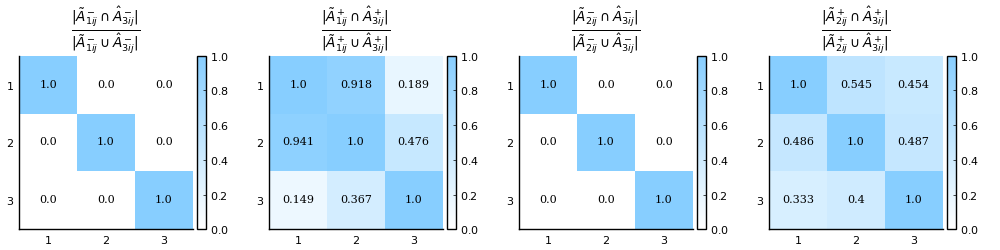

"非対角成分の算術平均: 0.0, 0.507, 0.0, 0.451"

"空集合の数　　　　　: 0, 0, 4, 0"

L"$A_{4}^+ = \begin{bmatrix} \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[   2.0, \emptyset,   4.0 \right] & \left[ 6.667, \emptyset,  12.0 \right] \\ \left[  0.25, \emptyset,   0.5 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[   2.0, \emptyset, 5.167 \right] \\ \left[ 0.083, \emptyset,  0.15 \right] & \left[ 0.194, \emptyset,   0.5 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] \end{bmatrix}$"

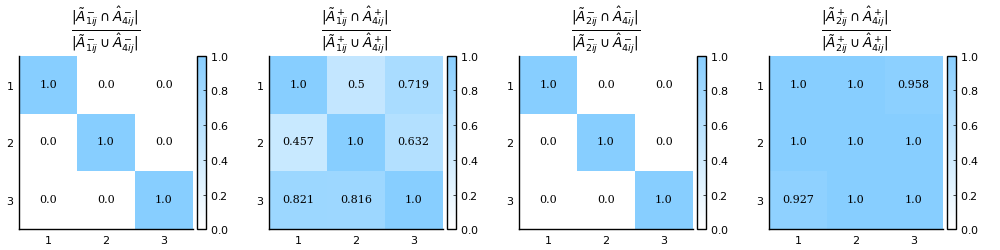

"非対角成分の算術平均: 0.0, 0.657, 0.0, 0.981"

"空集合の数　　　　　: 6, 0, 6, 0"

In [37]:
# 1 3 9
# 1/3 1 3
# 1/9 1/3 1

A₁ = [
    1..1 2.5..3.5 8..10
    (1/3.5)..(1/2.5) 1..1 2..4
    (1/10)..(1/8) (1/4)..(1/2) 1..1
]
A₂ = [
    1..1 2..4 7..12
    (1/4)..(1/2) 1..1 2..5
    (1/12)..(1/7) (1/5)..(1/2) 1..1
]

plotAll(A₁, A₂)

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.05, 1.1 \right] & \left[ 1.1, 1.21 \right] \\ \left[ 0.909, 0.952 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.1, 1.22 \right] \\ \left[ 0.826, 0.909 \right] & \left[ 0.82, 0.909 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.3 \right] & \left[ 0.8, 1.23 \right] \\ \left[ 0.769, 1.0 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.7, 1.3 \right] \\ \left[ 0.813, 1.25 \right] & \left[ 0.769, 1.429 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_{1}^+ = \begin{bmatrix} \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[   1.0, \emptyset,   1.3 \right] & \left[   0.8, \left[   1.1,   1.1 \right],  1.23 \right] \\ \left[ 0.769, \emptyset,   1.0 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[   0.7, \emptyset,   1.3 \right] \\ \left[ 0.813, \left[ 0.909, 0.909 \right],  1.25 \right] & \left[ 0.769, \emptyset, 1.429 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] \end{bmatrix}$"

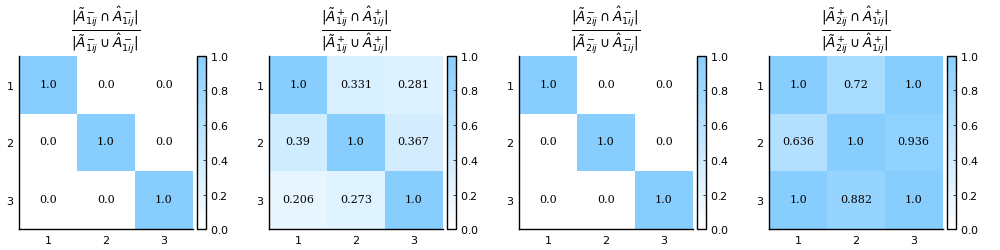

"非対角成分の算術平均: 0.0, 0.308, 0.0, 0.862"

"空集合の数　　　　　: 6, 0, 6, 0"

"\$A_{2}^+ = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  0.89, \\left[  1.05, 1.093 \\right],   1.3 \\right] & \\left[   0.8, \\left[ 1.182,  1.21 \\right], 1.316 \\right] \\\\ \\left[ 0.769, \\left[ 0.915, 0.952 \\right], 1.123 \\right] & \\left[ " ⋯ 30 bytes ⋯ "ght],   1.0 \\right] & \\left[   0.7, \\left[   1.1, 1.134 \\right],   1.3 \\right] \\\\ \\left[  0.76, \\left[ 0.826, 0.846 \\right],  1.25 \\right] & \\left[ 0.769, \\left[ 0.882, 0.909 \\right], 1.429 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

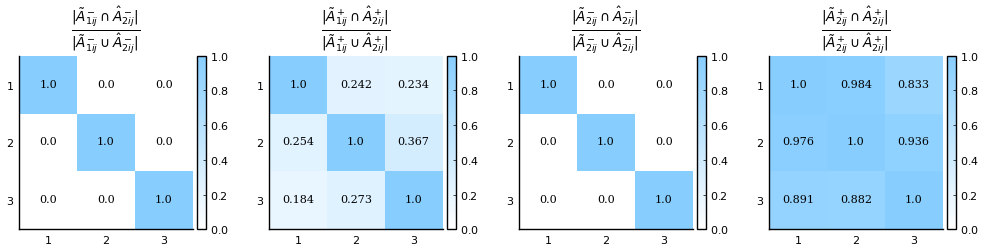

"非対角成分の算術平均: 0.0, 0.259, 0.0, 0.917"

"空集合の数　　　　　: 2, 0, 6, 0"

"\$A_{3}^+ = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 0.983, \\left[ 1.018, 1.031 \\right],   1.1 \\right] & \\left[ 1.134, \\left[ 1.155, 1.171 \\right], 1.243 \\right] \\\\ \\left[ 0.909, \\left[  0.97, 0.982 \\right], 1.018 \\right] & \\left[ " ⋯ 30 bytes ⋯ "ght],   1.0 \\right] & \\left[  1.05, \\left[   1.1,  1.17 \\right],  1.22 \\right] \\\\ \\left[ 0.804, \\left[ 0.854, 0.866 \\right], 0.882 \\right] & \\left[  0.82, \\left[ 0.855, 0.909 \\right], 0.952 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

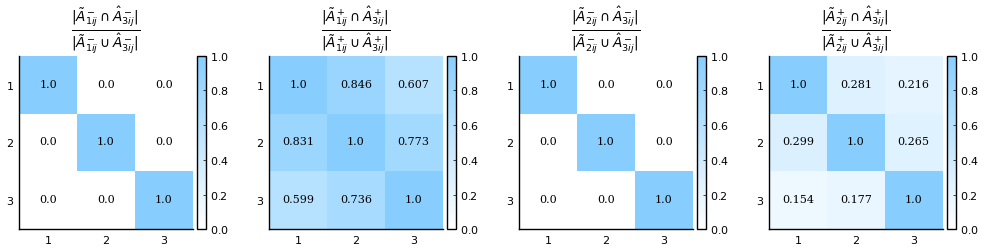

"非対角成分の算術平均: 0.0, 0.732, 0.0, 0.232"

"空集合の数　　　　　: 2, 0, 4, 0"

L"$A_{4}^+ = \begin{bmatrix} \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[ 0.883, \emptyset,   1.3 \right] & \left[   0.8, \emptyset,  1.23 \right] \\ \left[ 0.769, \emptyset, 1.132 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] & \left[ 0.659, \emptyset,   1.3 \right] \\ \left[ 0.813, \emptyset,  1.25 \right] & \left[ 0.769, \emptyset, 1.517 \right] & \left[   1.0, \left[   1.0,   1.0 \right],   1.0 \right] \end{bmatrix}$"

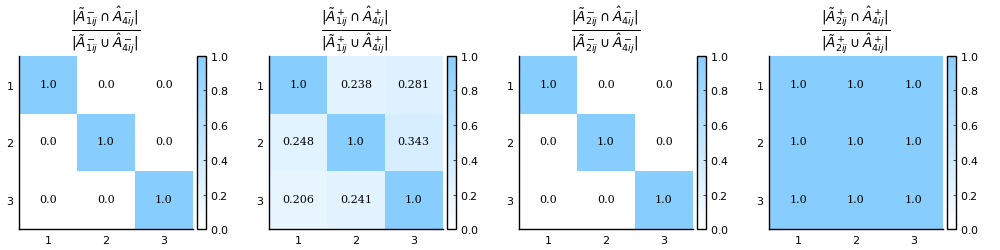

"非対角成分の算術平均: 0.0, 0.26, 0.0, 1.0"

"空集合の数　　　　　: 6, 0, 6, 0"

In [38]:
A₁ = [
    1..1 1.05..1.1 1.1..1.21
    (1/1.1)..(1/1.05) 1..1 1.1..1.22
    (1/1.21)..(1/1.1) (1/1.22)..(1/1.1) 1..1
]
A₂ = [
    1..1 1..1.3 0.8..1.23
    (1/1.3)..1 1..1 0.7..1.3
    (1/1.23)..(1/0.8) (1/1.3)..(1/0.7) 1..1
]

plotAll(A₁, A₂)